<h1 align="center">Employee Attrition</h1>
<h2 align="center">Uncover the factors lead to employee attrition and Predict attrition of valuable employees</h2>
<h3 align="center">Yuan Wang</h3>

# Loading package


In [23]:

import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go


# Loading data


In [24]:

data = pd.read_csv('WA_Fn-UseC_-HR-Employee-Attrition.csv')
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
Age                         1470 non-null int64
Attrition                   1470 non-null object
BusinessTravel              1470 non-null object
DailyRate                   1470 non-null int64
Department                  1470 non-null object
DistanceFromHome            1470 non-null int64
Education                   1470 non-null int64
EducationField              1470 non-null object
EmployeeCount               1470 non-null int64
EmployeeNumber              1470 non-null int64
EnvironmentSatisfaction     1470 non-null int64
Gender                      1470 non-null object
HourlyRate                  1470 non-null int64
JobInvolvement              1470 non-null int64
JobLevel                    1470 non-null int64
JobRole                     1470 non-null object
JobSatisfaction             1470 non-null int64
MaritalStatus               1470 non-null object
MonthlyIncome         

# Wage Distribution based on Attrition

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



[None, None]

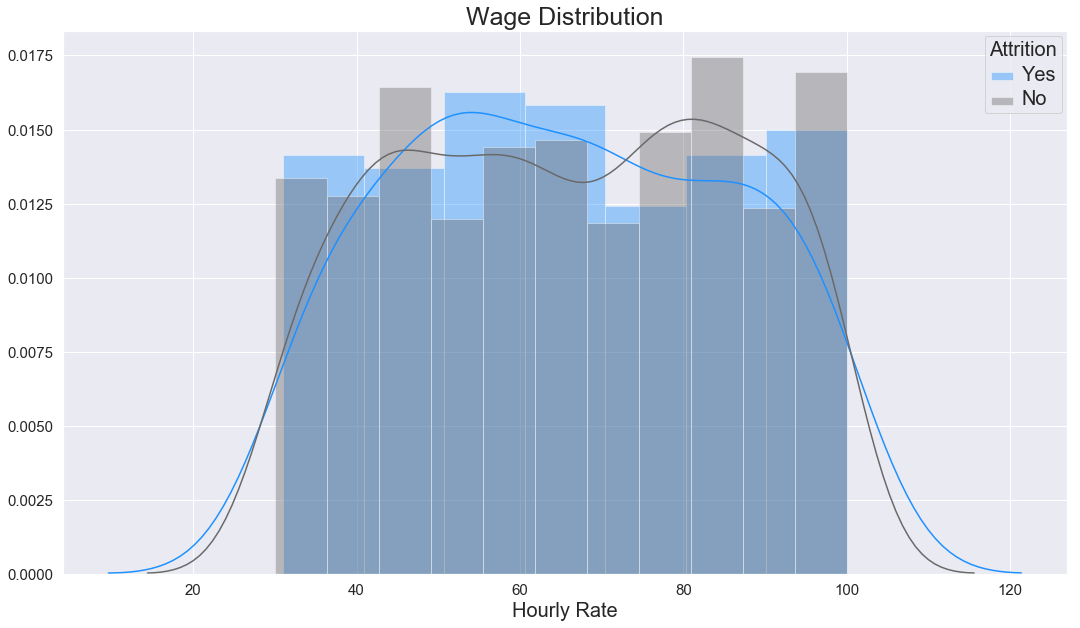

In [25]:

#from sklearn.preprocessing import LabelEncoder
#data['d_Attrition'] = LabelEncoder().fit_transform(data['Attrition'])

sns.set()
plt.figure(figsize=(18, 10))  


x1 = data[data.Attrition == 'Yes'].HourlyRate
x2 = data[data.Attrition ==  'No'].HourlyRate

sns.set_color_codes()
ax1 = sns.distplot(x1, color="dodgerblue", label="Yes")
ax2 = sns.distplot(x2, color="dimgrey", label="No")

ax1.axes.set_title("Wage Distribution",fontsize=25)
ax1.set_xlabel("Hourly Rate", fontsize=20)
ax1.tick_params(labelsize=15)
ax1.legend().set_title("Attrition")

plt.setp(ax1.get_legend().get_texts(), fontsize='20') # for legend text
plt.setp(ax1.get_legend().get_title(), fontsize='20') # for legend title

#ax.legend(loc='upper left', fontsize=20,bbox_to_anchor=(0, 1.1))
#sns.plt.show()


# Feature Selection: Factors that lead to Employee Attrition

In [30]:

# Data Preparation

# Categorical columns
cat_cols   = data.nunique()[data.nunique() < 10].keys().tolist()
cat_cols   = [x for x in cat_cols if x not in ["Attrition"]]
num_cols   = [x for x in data.columns if x not in cat_cols + ["Attrition"] + ['EmployeeNumber']]
bin_cols   = data.nunique()[data.nunique() == 2].keys().tolist()
multi_cols = [i for i in cat_cols if i not in bin_cols]

# Label encoding
le = LabelEncoder()
for i in bin_cols :
    data[i] = le.fit_transform(data[i])
data = pd.get_dummies(data = data,columns = multi_cols )

# Scale columns
std = StandardScaler()
scaled = std.fit_transform(data[num_cols])
scaled = pd.DataFrame(scaled,columns=num_cols)

df_data_og = data.copy()
data = data.drop(columns = num_cols,axis = 1)
data = data.merge(scaled,left_index=True,right_index=True,how = "left")


In [31]:

# AdaBoost Classification

data = data.drop(columns = ['EmployeeNumber','YearsWithCurrManager','MonthlyIncome'])

#data = data.drop(columns = 'd_Attrition')

y = np.array(data.Attrition.tolist())
data = data.drop('Attrition',1)
X = np.array(data.as_matrix())
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), algorithm="SAMME", n_estimators=200)
dbt_clf = bdt.fit(X_train, y_train)


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.



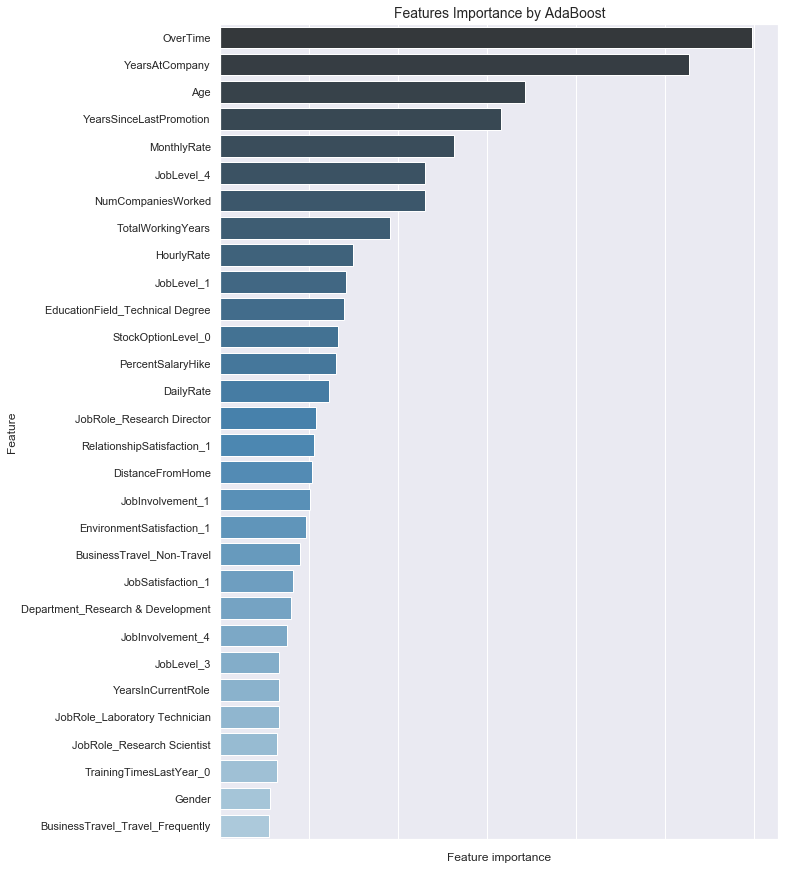

In [32]:

# Feature Importance Plot

def plot_feature_importance(model):
    tmp = pd.DataFrame({'Feature': list(data), 'Feature importance': model.feature_importances_})
    tmp = tmp.sort_values(by='Feature importance',ascending=False).head(30)
    plt.figure(figsize = (10,15))
    plt.title('Features Importance by AdaBoost',fontsize=14)
    s = sns.barplot(y='Feature',x='Feature importance',data=tmp, orient='h', palette="Blues_d")
    s.set_xticklabels(s.get_xticklabels(),rotation=90)
    plt.savefig('Feature_Importance.png')
    plt.show()
    
plot_feature_importance(dbt_clf)


# Features Discussion: Employee Age & Year at Company

In [26]:

# Age Distribution

Attrition_by_Age = pd.DataFrame(pd.crosstab(data['Age'],data['Attrition'])).reset_index()
Attrition_by_Age['Attr%'] = Attrition_by_Age['Yes'] / (Attrition_by_Age['Yes'] + Attrition_by_Age['No']) * 100
Attrition_by_Age = Attrition_by_Age.sort_values(by = ['Age'])


In [27]:

# Age Distribution Plot

tmp = Attrition_by_Age
var = 'Age'

trace1 = go.Bar(
    x=tmp[var],
    y=tmp['Yes'],
    name='Yes',
    marker=dict(color='rgb(49,130,189)')
)

trace2 = go.Bar(
    x=tmp[var],
    y=tmp['No'],
    name='No',
    marker=dict(color='rgb(204,204,204)')
)

trace3 = go.Scatter(
    x=tmp[var],
    y=tmp['Attr%'],
    name='Attr%',
    yaxis = 'y2',
    marker=dict(color='red'),
)

layout = dict(
    title = str(var),
    xaxis=dict(range= [18, 55]),
    yaxis=dict(range= [-0, 70],
               title= 'Count'), 
    yaxis2=dict(range= [-0, 70],
                overlaying= 'y',
                anchor= 'x',
                side= 'right',
                zeroline=False,
                showgrid= False,
                title= '% Attrition'),
    legend=dict(x=0.8,y=1,))

data_fig = [trace1, trace2, trace3]
fig = go.Figure(data=data_fig, layout=layout)
py.iplot(fig, filename = var)


In [28]:

# Year at Company Distribution

Attrition_by_Year = pd.DataFrame(pd.crosstab(data['YearsAtCompany'],data['Attrition'])).reset_index()
Attrition_by_Year['Attr%'] = Attrition_by_Year['Yes'] / (Attrition_by_Year['Yes'] + Attrition_by_Year['No']) * 100
Attrition_by_Year = Attrition_by_Year.sort_values(by = ['YearsAtCompany'])


In [36]:

# Year Distribution Plot

tmp = Attrition_by_Year
var = 'YearsAtCompany'

trace1 = go.Bar(
    x=tmp[var],
    y=tmp['Yes'],
    name='Yes',
    marker=dict(color='rgb(49,130,189)')
)

trace2 = go.Bar(
    x=tmp[var],
    y=tmp['No'],
    name='No',
    marker=dict(color='rgb(204,204,204)')
)

trace3 = go.Scatter(
    x=tmp[var],
    y=tmp['Attr%'],
    name='Attr%',
    yaxis = 'y2',
    marker=dict(color='red'),
)

layout = dict(
    title = str(var),
    xaxis=dict(range= [0, 20]),
    yaxis=dict(range= [0, 200],
               title= 'Count'), 
    yaxis2=dict(range= [0, 50],
                overlaying= 'y',
                anchor= 'x',
                side= 'right',
                zeroline=False,
                showgrid= False,
                title= '% Attrition'),
    legend=dict(x=0.8,y=1,))

data_fig = [trace1, trace2, trace3]
fig = go.Figure(data=data_fig, layout=layout)
py.iplot(fig, filename = var)
